# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [199]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from plotly.subplots import make_subplots
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [200]:
import sys
import re
import nltk
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/minyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/minyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/minyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [202]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [203]:
#dataframe of number of articles each user interacts with. Removeds duplicate
print(df.groupby('email')['article_id'].nunique())
#dataframe of number of articles each user interacts with. Duplicate articles included
print(df.groupby('email')['article_id'].count())


email
0000b6387a0366322d7fbfc6434af145adf7fed1    12
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     5
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     1
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     2
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    27
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81     7
fffb93a166547448a0ff0232558118d59395fecd     6
Name: article_id, Length: 5148, dtype: int64
email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff

In [204]:
#build the dataframe records the number of articles each user interacts with. Duplicate article counts have been removed
num_articles_by_user = df.groupby('email')['article_id'].nunique()

In [205]:
#descriptive statistics of dataset overview
num_articles_by_user.describe()

count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64

In [206]:
#build the dataframe records the number of articles each user interacts with. Duplicate article counts have been removed
num_articles_by_any_user = df.groupby('email')['email'].count()

In [207]:
#descriptive statistics of dataset overview
num_articles_by_any_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [208]:
print(num_articles_by_user.index)
print(num_articles_by_user.values)

Index(['0000b6387a0366322d7fbfc6434af145adf7fed1',
       '001055fc0bb67f71e8fa17002342b256a30254cd',
       '00148e4911c7e04eeff8def7bbbdaf1c59c2c621',
       '001a852ecbd6cc12ab77a785efa137b2646505fe',
       '001fc95b90da5c3cb12c501d201a915e4f093290',
       '0042719415c4fca7d30bd2d4e9d17c5fc570de13',
       '00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7',
       '008ba1d5b4ebf54babf516a2d5aa43e184865da5',
       '008ca24b82c41d513b3799d09ae276d37f92ce72',
       '008dfc7a327b5186244caec48e0ab61610a0c660',
       ...
       'ff6e82c763fe2443643e48a03e239eb635f406dc',
       'ff7a0f59ba022102ad22981141a7182c4d8273c3',
       'ff833869969184d86f870f98405e7988eccc2309',
       'ff979e07f9d906a32ba35a9b75fd9585f6306dbc',
       'ffaefa3a1bc2d074d9a14c9924d4e67a46c35410',
       'ffc6cfa435937ca0df967b44e9178439d04e3537',
       'ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d',
       'ffe3d0543c9046d35c2ee3724ea9d774dff98a32',
       'fff9fc3ec67bd18ed57a34ed1e67410942c4cd81',
       'fffb93a16654

In [209]:
df_num_articles_by_users = pd.DataFrame({'user_id':num_articles_by_user.index, 'number_of_articles_by_user':num_articles_by_user.values})

In [210]:
fig = px.histogram(df_num_articles_by_users,x='number_of_articles_by_user')
fig.show()

In [211]:
# Fill in the median and maximum number of user_article interactios below

median_val = num_articles_by_user.median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =num_articles_by_any_user.max() # The maximum number of user-article interactions by any 1 user is ______.
print(median_val)
print(max_views_by_user)

3.0
364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [212]:
# Find and explore duplicate articles
print(df_content.shape)
print(df_content['article_id'].nunique())

(1056, 5)
1051


In [213]:
# Find and explore duplicate articles, identify article_id with duplicates
article_content=df_content.groupby('article_id')['article_id'].count()
article_content[article_content.values>1]

article_id
50     2
221    2
232    2
398    2
577    2
Name: article_id, dtype: int64

In [214]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
print(df_content.shape)

(1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [215]:
#The number of unique articles that have at least one interaction
df_article = df.groupby('article_id')['email'].count()
unique_a = df_article[df_article.values>0].count()
print(unique_a)

714


In [216]:
# The number of unique articles on the IBM platform
total_a = df_content['article_id'].nunique()
print(total_a)

1051


In [217]:
# The number of unique users
unique_u = df['email'].dropna()
unique_u = unique_u.nunique()
print(unique_u)

5148


In [218]:
# The number of user-article interactions
user_article_i = len(df)
print(user_article_i)

45993


In [219]:
unique_articles = unique_a# The number of unique articles that have at least one interaction
total_articles = total_a# The number of unique articles on the IBM platform
unique_users = unique_u # The number of unique users
user_article_interactions = user_article_i# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [220]:
# The most viewed article in the dataset as a string with one value following the decimal 
df.groupby('article_id')['article_id'].count().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1113.0      1
1119.0      1
984.0       1
1127.0      1
1266.0      1
Name: article_id, Length: 714, dtype: int64

In [221]:
print(df.groupby('article_id')['article_id'].count().sort_values(ascending=False).index[0])
print(df.groupby('article_id')['article_id'].count().sort_values(ascending=False).values[0])

1429.0
937


In [222]:
most_viewed_article_id = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).index[0]# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_viewed_article_id)
max_views = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).values[0]# The most viewed article in the dataset was viewed how many times?

In [223]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [224]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [225]:
df.groupby('article_id')['article_id'].count().sort_values(ascending=False).index

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0,
              ...
               662.0, 1200.0, 1092.0,  653.0, 1344.0, 1113.0, 1119.0,  984.0,
              1127.0, 1266.0],
             dtype='float64', name='article_id', length=714)

In [226]:
ranked_interactions = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).index
number_interactions = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).values
#pull article title and article_id for each article
article_titles = df[['article_id','title']].drop_duplicates()
#build ranked articles 
ranked_articles_df = pd.DataFrame({'ranked_article_id': ranked_interactions, 'num_ratings': number_interactions})
ranked_articles_df = pd.merge(ranked_articles_df, article_titles, left_on='ranked_article_id', right_on='article_id').drop('article_id', axis=1)

In [227]:
ranked_articles_df.head()

,ranked_article_id,num_ratings,title
0,1429.0,937,use deep learning for image classification
1,1330.0,927,insights from new york car accident reports
2,1431.0,671,visualize car data with brunel
3,1427.0,643,"use xgboost, scikit-learn & ibm watson machine..."
4,1364.0,627,predicting churn with the spss random tree alg...


In [228]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    #pull the ranking, and number of interactions for each articles
    df_article = df.groupby('title')['title'].count().sort_values(ascending=False)
    df_article =pd.DataFrame(df_article)
    df_article.rename(columns={'title': 'article_interactions'}, inplace=True)
    df_article = df_article.sort_values(by=['article_interactions'],ascending=False).reset_index()
    df_article['rank']= df_article.index+1
    ####
    
    top_articles = list(df.groupby('title').count().sort_values(by='user_id',ascending=False).head(n).index)
   
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    #pull the ranking, and number of interactions for each articles
    top_articles = list(df.groupby('article_id').count().sort_values(by='user_id',ascending=False).head(n).index)
   
    return top_articles # Return the top article ids

In [229]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [230]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [231]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Create user-by-item matrix
    user_by_article = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_by_article[user_by_article>1]=1
    user_item=user_by_article.fillna(0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [232]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [234]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    user_id_series=np.array(user_item.index)
    # compute similarity of each user to the provided user
    val=user_item[user_item.index==user_id]
    val_similarity = val.dot(np.transpose(user_item))
    # sort by similarity
    # function: argsort, which returns the indices of the sorted elements
    val_similarity_indices = np.argsort(-val_similarity)
    # create list of just the ids
    val_similarity_ids = list(user_id_series[val_similarity_indices])
    # remove the own user's id
    most_similar_users=[]
    for i in range(len(user_item)):
        if val_similarity_ids[0][i] != user_id:
             most_similar_users.append(val_similarity_ids[0][i])
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [235]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 3870, 131, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [236]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
     # pull the movie titles based on the indices
    article_names = set(df[df['article_id'].isin(article_ids)]['title'])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Pull only the reviews the user has seen
    temp = user_item.loc[user_id][user_item.loc[user_id].values== 1].index
    article_ids = np.array(temp)
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Keep the recommended articles ids here
    recs_ids = np.array([])
    #recs = np.array([])
    
    # Your code here
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    # articles been read by target users
    target_user_article_ids, target_user_article_names= get_user_articles(user_id, user_item=user_item)
    
   
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in most_similar_users:
        neighbs_likes_ids,neighbs_likes_names = get_user_articles(neighbor,user_item=user_item)
        #Obtain recommendations for each neighbor
        # These will be the recommendations - continue until 10 recs 
        new_recs_ids = np.setdiff1d(neighbs_likes_ids, target_user_article_ids, assume_unique=True)
        #for article in new_recs_ids:
            # Update recs with new recs
        recs_ids = np.unique(np.concatenate([recs_ids, new_recs_ids], axis=0))
        
            # If we have enough recommendations exit the loop
        if len(recs_ids) > m-1:
            break
    
    # Pull movie titles using movie ids
    recs = recs_ids[:m]
    
    return recs # return your recommendations for this user_id    

In [237]:
####alternative to above,it returns 10!!!!!
####################################!!!!!!#####################################

def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
     # pull the movie titles based on the indices
    article_names = set(df[df['article_id'].isin(article_ids)]['title'])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Pull only the reviews the user has seen
    temp = user_item.loc[user_id][user_item.loc[user_id].values== 1].index
    article_ids = np.array(temp)
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Keep the recommended articles ids here
    #recs_ids = np.array([])
    recs_ids = []
    #recs = np.array([])
    
    # Your code here
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    # articles been read by target users
    target_user_article_ids, target_user_article_names= get_user_articles(user_id, user_item=user_item)
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in most_similar_users:
        neighbs_likes_ids,neighbs_likes_names = get_user_articles(neighbor,user_item=user_item)
        #Obtain recommendations for each neighbor
        # These will be the recommendations - continue until 10 recs 
        new_recs_ids = np.setdiff1d(neighbs_likes_ids, target_user_article_ids, assume_unique=True)
        new_recs_ids = list(new_recs_ids)
        for article in new_recs_ids:
            if article not in recs_ids:
                recs_ids.append(article)
                if len(recs_ids) > m-1:
                    break
        if len(recs_ids) > m-1:
                    break
    # Pull movie titles using movie ids
    recs = recs_ids
    return recs # return your recommendations for this user_id    

In [238]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

{'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'graph-based machine learning',
 'higher-order logistic regression for large datasets',
 'the 3 kinds of context: machine learning and the art of the frame',
 'this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'using brunel in ipython/jupyter notebooks',
 'using machine learning to predict parking difficulty'}

In [239]:
get_user_articles(20)[0]

array([ 232.,  844., 1320.])

In [240]:
get_user_articles(2)[1]

{'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'using deep learning to reconstruct high-resolution audio'}

In [241]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([232.,  844., 1320.])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024., 1176., 1305., 1314., 1422., 1427.])
assert set(get_user_articles(2)[1]) == set(['build a python app on the streaming analytics service','gosales transactions for naive bayes model','healthcare python streaming application demo','use r dataframes & ibm watson natural language understanding','use xgboost, scikit-learn & ibm watson machine learning apis','using deep learning to reconstruct high-resolution audio'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [242]:
df_article = df.groupby('article_id')['article_id'].count().sort_values(ascending=False)
df_article =pd.DataFrame(df_article)
df_article.rename(columns={'article_id': 'article_interactions'}, inplace=True)
df_article = df_article.sort_values(by=['article_interactions'],ascending=False).reset_index()
df_article['rank']= df_article.index+1
df_article.head()

,article_id,article_interactions,rank
0,1429.0,937,1
1,1330.0,927,2
2,1431.0,671,3
3,1427.0,643,4
4,1364.0,627,5


In [248]:
#######alternatives##########
#use get_top_article_ids function for article orders 
#############################


def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # compute interactions for each user, and build the dataframe descending by the total counts of article interactions
    ranked_users = df.groupby(['user_id'])['user_id'].count().sort_values(ascending=False)
    ranked_users =pd.DataFrame(ranked_users)
    ranked_users.rename(columns={'user_id': 'interactions'}, inplace=True)
    ranked_users = ranked_users.sort_values(by=['interactions'],ascending=[False])
    
    # compute similarity of each user to the provided user
    val=user_item[user_item.index==user_id]
    val_similarity = val.dot(np.transpose(user_item))
    val_similarity = np.transpose(val_similarity)
    val_s=pd.DataFrame(val_similarity)
    val_s.columns=['similarity']

    # compute interactions for each users
   
    
    # sort by similarity, and number of article interactions
    ranked_users = ranked_users.join(val_s).reset_index().sort_values(by=['similarity','interactions'],ascending=[False,False])
    
    # remove the own user's id
    neighbors_df = ranked_users[ranked_users.user_id != user_id]
        
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
     # Keep the recommended articles ids here
    recs_ids = []
    #recs = np.array([])
    
    # Your code here
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    most_similar_users = neighbors_df['user_id']
    
    #ranking articles based on top_article function
    
    df_article = df.groupby('article_id')['article_id'].count().sort_values(ascending=False)
    df_article =pd.DataFrame(df_article)
    df_article.rename(columns={'article_id': 'article_interactions'}, inplace=True)
    df_article = df_article.sort_values(by=['article_interactions'],ascending=False).reset_index()
    df_article['rank']= df_article.index+1
    
    # articles been read by target users
    target_user_article_ids, target_user_article_names= get_user_articles(user_id, user_item=user_item)
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in most_similar_users:
        neighbs_likes_ids,neighbs_likes_names = get_user_articles(neighbor,user_item=user_item)
        sorted_articles = pd.DataFrame()
        for a in neighbs_likes_ids:
            rank = df_article[df_article['article_id']== a]['rank']
            sorted_df= pd.DataFrame({'neighbs_likes_ids':[a],'rank':rank})
            sorted_articles = sorted_articles.append(sorted_df)

        sorted_articles=sorted_articles.sort_values(['rank'],ascending=True)
        sorted_articles_ids=np.array(sorted_articles['neighbs_likes_ids'])
        #Obtain recommendations for each neighbor
        # These will be the recommendations - continue until 10 recs 
        new_recs_ids = np.setdiff1d(sorted_articles_ids, target_user_article_ids, assume_unique=True)
        new_recs_ids = list(new_recs_ids)
        for article in new_recs_ids:
            if article not in recs_ids:
                recs_ids.append(article)
                if len(recs_ids) > m-1:
                    break
        if len(recs_ids) > m-1:
            break       
        
        
    # Pull movie titles using movie ids
    recs = recs_ids
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names

In [250]:
#make recommendations using User-User Based Collaborative Filtering
def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    
    # All the users we need to make recommendations for
    users = np.unique(df['user_id'])
    n_users = len(users)
    
    #Store all recommendations in this dictionary
    all_recs = dict()
    
    # Make the recommendations for each user
    for user in users[0:10]:
        all_recs[user] = user_user_recs_part2(user, num_recs)
    
    return all_recs

all_recs = all_recommendations(1)

In [251]:
all_recs.items()

dict_items([(1, ([1330.0], {'insights from new york car accident reports'})), (2, ([1429.0], {'use deep learning for image classification'})), (3, ([1427.0], {'use xgboost, scikit-learn & ibm watson machine learning apis'})), (4, ([230.0], {'web picks (week of 23 january 2017)'})), (5, ([1429.0], {'use deep learning for image classification'})), (6, ([1330.0], {'insights from new york car accident reports'})), (7, ([1330.0], {'insights from new york car accident reports'})), (8, ([57.0], {'transfer learning for flight delay prediction via variational autoencoders'})), (9, ([1429.0], {'use deep learning for image classification'})), (10, ([1431.0], {'visualize car data with brunel'}))])

In [249]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
{'apache spark lab, part 1: basic concepts', 'movie recommender system with spark machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'analyze energy consumption in buildings', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss'}


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [253]:
#get_top_sorted_users(1, df=df, user_item=user_item).iloc[0]['neighbor_id']
get_top_sorted_users(131, df=df, user_item=user_item).head(30)

,user_id,interactions,similarity
11,3870,144,74.0
1,3782,363,39.0
0,23,364,38.0
4,203,160,33.0
5,4459,158,33.0
2,98,170,29.0
3,3764,169,29.0
7,49,147,29.0
9,3697,145,29.0
6,242,148,25.0


In [254]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).iloc[0]['user_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9]['user_id']# Find the 10th most similar user to user 131

In [255]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

No, the above solution won't work for a new user. As in the database, there is no records of article interactions regarding the new user. It can't find similar users and recommend article likes of similar users' and recommend to the new user.

In this case, we could further include knowledge based solutions, for example, the most popular articles among all users to any new user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [578]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df=df)# Your recommendations here



In [579]:
get_top_article_ids(10, df=df)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [580]:
assert set(new_user_recs) == set([1429.0,1330.0,1431.0,1427.0,1364.0,1314.0,1293.0,1170.0,1162.0,1304.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [776]:
#Before finding recommendations, rank the users' article interactions from highest to lowest. You will move through the movies in this order looking for other similar movies.

In [724]:
# create a dataframe, ranked by number of interactions of each articles for each user 
ranked_user_article = df.groupby(['user_id','article_id'])['article_id'].count().sort_values(ascending=False)
df1 = pd.DataFrame(ranked_user_article)
df1.rename(columns={'article_id': 'Counts'}, inplace=True)
df1 = df1.reset_index().sort_values(by=['Counts','user_id'],ascending=[False,True])

In [5]:
def tokenize(text):
    '''
    INPUT:
        text:raw message
    OUTPUT:
        clean_tokens:tokenized words
    DESCRIPTION:
        The function is to process the scentence, normalize texts, tokenize texts.
        Convert all cases to lower cases, remove extra space,stop words, and 
        reduce words to their root form.
    '''
    clean_tokens=[]    
    #remove punctuation,normalize case to lower cases, and remove extra space
    text = re.sub(r"[^a-zA-Z0-9]"," ",text.lower()).strip()
    
    #tokenize text
    tokens=word_tokenize(text)
    
    for w in tokens:  
        #remove stop words
        if w not in stopwords.words("english"):
        #lemmatization
        #reduce words to their root form
            lemmed = WordNetLemmatizer().lemmatize(w)
            clean_tokens.append(lemmed)
    return clean_tokens

In [6]:
####s2
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer(smooth_idf=False))
        ])


In [58]:
def find_similar_articles(article_id, df):
    '''
    INPUT
    article_id - a article_id
    movies_df - original movies dataframe
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    #drop duplicate articles and get article titles
    new_df = df.drop_duplicates(subset='article_id')
    titles = np.array(new_df['title'])
    
    #use pipeline defined above to convert texts to numeric matrix
    tfidf = pipeline.fit_transform(titles)
    # convert sparse matrix to numpy array
    titles_tfidf = tfidf.toarray()

    # dot product to get similar articles
    dot_prod_titles = titles_tfidf.dot(np.transpose(titles_tfidf))

    # find the row of each article id
    article_idx = np.where(new_df['article_id'] == article_id)[0][0]

    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_idxs = np.where(dot_prod_titles[article_idx] >= 0.2*np.max(dot_prod_titles[article_idx]))[0]
    # remove article itself
    similar_idxs = np.setdiff1d(similar_idxs,article_idx)
    
    # pull the titles based on the indices
    similar_articles = np.array(new_df.iloc[similar_idxs, ]['title'])

    return similar_articles

In [116]:
 def make_recommendations(_id, _id_type='article', df=df, rec_num=5):
        '''
        INPUT:
        _id - either a user or movie id (int)
        _id_type - "movie" or "user" (str)
        rec_num - number of recommendations to return (int)

        OUTPUT:
        recs - (array) a list or numpy array of recommended movies like the
                       given movie, or recs for a user_id given
        '''
        # if the user is available from the matrix factorization data,
        # I will use this and rank movies based on the predicted values
        # For use with user indexing
        new_df1 = df.drop_duplicates(subset='user_id')
        user_id_series = np.array(new_df1['user_id'])
        
        new_df2 = df.drop_duplicates(subset='article_id')
        article_ids_series = np.array(new_df2['article_id'])
        
        rec_ids, rec_names = None, None
        if _id_type == 'user':
            if _id in user_id_series:
                # Get the index of which row the user is in for use in U matrix
                rec_ids, rec_names = user_user_recs_part2(_id, m=rec_num)
                rec_names = list(rec_names)
            else:
                # if we don't have this user, give just top ratings back
                rec_names = list(get_top_articles(rec_num))
                print("Because this user wasn't in our database, we are giving back the top article recommendations for all users.")

        # Find similar movies if it is a movie that is passed
        else:
            if _id in article_ids_series:
                rec_names = list(find_similar_articles(_id, df))[:rec_num]
            else:
                print("That movie doesn't exist in our database.  Sorry, we don't have any recommendations for you.")

        return rec_names



`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

**content-based recommendation**

Content features, essentially key words was identified by condcting NPL analysis on article titles. Dot product was used to calculate the similarities among articles based on article features. Given a certain article, the most similar articles is provided based on dot product result.

**novelity**

- While conducting NPL analysis, pipeline was used to keep the process clean and easy to alter later on.

- The recommendation system has been further built into a comprehensive one: blend with content-based recommendation, collaborative filtering and knowledge based solutions. It expands the capability to give recomendations to either articles or users in database, and even to brand new users.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [117]:
# make recommendations for a brand new user
rec1=make_recommendations(0, _id_type='user', df=df, rec_num=5)
print('For the new user, here are the recommendations:{}'.format(str(rec1)))


# make a recommendations for a user who only has interacted with article id '1427.0'
rec2=make_recommendations(1427.0, _id_type='article', df=df, rec_num=5)
print('For a user who interacts with the given article , here are the recommendations:{}'.format(str(rec2)))

Because this user wasn't in our database, we are giving back the top article recommendations for all users.
For the new user, here are the recommendations:['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']
For a user who interacts with the given article , here are the recommendations:['use apache systemml and spark for machine learning', 'use r dataframes & ibm watson natural language understanding', 'python machine learning: scikit-learn tutorial', 'learn tensorflow and deep learning together and now!', 'learn about data science in world of watson']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [581]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [582]:
# quick look at the matrix
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [583]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)# use the built in to get the three matrices

In [584]:
u.shape

(5149, 5149)

In [585]:
# Change the dimensions of u, s, and vt as necessary to use four latent features
# update the shape of u and store in u_new
u_new = u[:,:len(s)]# change the shape of u here

# update the shape of s and store in s_new
s_new =np.diag(s) #change the shape of s as necessary 

# Because we are using 4 latent features and there are only 4 movies, 
# vt and vt_new are the same
vt_new = vt# change the shape of vt as necessary

**Provide your response here.**

Need to pay attention that SVD in NumPy will not work when the matrix has missing values. The user-item matrix was sparsed in this case,  and in the exercise. The difference was that in exercixe, it showed Na in user-item matrix where user and item had none interactions. While, it replaced with 0 in this case. Becuase of missing values in the matrics, SVD didn't work in the exercise. As Na values were replaced with 0 in the practice, SVD method worked in this practice.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

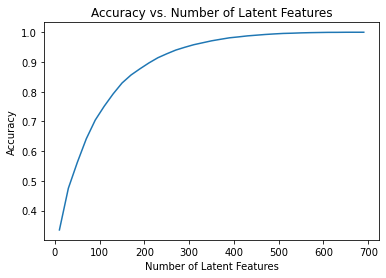

In [586]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [594]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [595]:
#cold start probelm
#users in the test set but not in the training set can not be predicted
#articles in the test set but not in the training set can not be predicted


In [596]:
train_idx1 = user_item_train.index
train_arts1 = user_item_train.columns
match_idx = list(train_idx1.intersection(test_idx))
match_arts = list(train_arts1.intersection(test_arts))
#number of users in the test set can be predicted
print(len(match_idx))
#number of articles in the test set can be predicted
print(len(match_arts))
#number of articles in the test sets
print(len(test_arts))
#number of users in the test set
print(len(test_idx))

20
574
574
682


In [597]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [598]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)# fit svd similar to above then use the cells below

In [599]:
#find the subset of rows in the user_item_test dataset that you can predict using this matrix decomposition
train_common_idx = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)

In [600]:
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_col]
print('test: ', u_test.shape, vt_test.shape)

test:  (20, 4487) (714, 574)


In [601]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [602]:
train_idx = user_item_train.index
common_idx = list(set(train_idx) & set(test_idx))
print(common_idx)

[3968, 4487, 4231, 3093, 3989, 3990, 3740, 3998, 4002, 4274, 3777, 4293, 3527, 3532, 3024, 3801, 3684, 2917, 4204, 3193]


In [603]:
user_item_test_subset = user_item_test.loc[common_idx]

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_est)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errs.append(test_err)

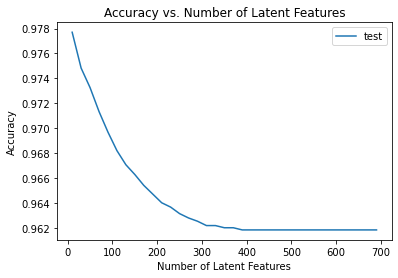

In [604]:
plt.plot(num_latent_feats, 1 - (np.array(test_sum_errs)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])), label='test');
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Provide your response here.**

#### Evaluation metrics
Accuracy was used to evaluate the model's performance. One issue was that while calculating the accuracy, the sum of absolute error was divided by the size of user_by_article matrix. Considering that the user_by_article matrix was very sparsed, and huge amount of user-article had none connections. The accuracy wasn't calculated correctly. Instead, we should only count the number of user-article that had connections, and evaluate the prediction errors upon those. Specifically, the sum of absolute error should be divided by the number of non-0 user-article counts.

#### Metrics selection
Regarding metrics selection for model evaluation, accuracy was used in this case. However,accuracy metric is mostly for classification model evalution. To make a fair asscessment of the model, regression metrics are more appropriate, for exaple,vMean-Squared Error (MSE). 

#### Evaluation robustness  issue
The dataset was splited into training and testing sets. But it only got 20 users in testing set that could be used for model validation, as such users were also in the training set. The very limited number of users for model validation was not sufficient and not robust for evaluating the model. We could futher shuffle datasets before spliting training/testing data sets and iterate modeling process for stable and more convincing evaluation results.

#### Offline/Online recommendation issue
The recommendation in this practice actually don't work very well for offline testing. In offline testing, it is ideal to not just obtain a list of recommendations for each individual, because we ultimately don't know if a user doesn't read an article because they don't like it, or because they just haven't read it yet (but would like it). Rather, it would be great if we have an idea of how much each user would like each item using a predicted rating. Then we can compare this predicted rating to the actual rating any individual gives to an item in the future.

Moreover,  an online evaluation technique like A/B testing can be further used. It is common in practice to set up online recommendations to have an "old" version of recommended articles, which is compared to a new system that uses the new recommendation strategy. In practice, metrics like higher engagement, clicks can be used to evaluate A/B testing result.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [256]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1